In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

Importing the package that Nichole and I helped to create,

In [6]:
import OD_growth_finder as od

In [7]:
import pandas as pd

We create an "OD_growth_experiment" class which serves as a container for all relevant experimental info. It requires a path to an excel file that our "Plate Reader" created and a smoothing factor required when evaluating derivatives.

In [8]:
experiment = od.OD_growth_experiment('2016_12_13_yeast_cyclo_dex_growth.xls', s=0.4)

Internally, the experimental data is just a pandas dataframe that we do operations on, i.e.

In [9]:
experiment.data.iloc[0:6,0:6]

,A1,A2,A3,A4,A5,A6
0,0.166,0.168,0.166,0.143,0.144,0.145
1,0.168,0.171,0.167,0.145,0.147,0.152
2,0.172,0.174,0.170,0.146,0.147,0.152
3,0.174,0.177,0.173,0.148,0.149,0.153
4,0.181,0.182,0.178,0.150,0.151,0.154
5,0.185,0.188,0.185,0.152,0.152,0.158


In this experiment, we exposed many different cultures to different conditions. There were 96 cultures, each denoted by an alpha-numeric combination, i.e. A1, A2, A3, etc. 

To keep track of what was in each of the 96 cultures, we created a separate "plate-map" file; let's import that now. 

In [10]:
layout = pd.read_excel('plate_map.xls')

In [13]:
layout.head(6)

,Well,Condition,Number
0,A1,dex,0.1
1,A2,dex,0.1
2,A3,dex,0.1
3,A4,cyclo room,500.0
4,A5,cyclo room,500.0
5,A6,cyclo room,500.0


So, each well has a "Condition" which describes what's in the well. If appropriate, the condition has an associated number.

We need to merge this plate map with the data above. The easiest way is to do this is to "unstack" the original experimental data (i.e. each row corresponds to a separate measurement), or 

In [22]:
new_data = experiment.data.unstack().to_frame().reset_index()
new_data.rename(columns={'level_0':'Well',
                        'level_1':'time_index',
                        0:'OD600'}, inplace=True)

In [23]:
new_data.head(5)

,Well,time_index,OD600
0,A1,0,0.166
1,A1,1,0.168
2,A1,2,0.172
3,A1,3,0.174
4,A1,4,0.181


It is now easy to combine the plate map with our experimental measurements.

In [24]:
combined_data = pd.merge(new_data, layout, how='inner', on='Well')

In [25]:
combined_data.head(5)

,Well,time_index,OD600,Condition,Number
0,A1,0,0.166,dex,0.1
1,A1,1,0.168,dex,0.1
2,A1,2,0.172,dex,0.1
3,A1,3,0.174,dex,0.1
4,A1,4,0.181,dex,0.1


Let's plot the growth of all of our microbes.

In [26]:
combined_data['time'] = experiment.elapsed_minutes[combined_data['time_index'].values]

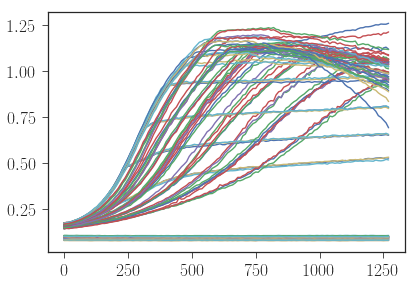

In [27]:
for name, cur_data in combined_data.groupby('Well'):
    plt.plot(cur_data['time'], cur_data['OD600'])

We need to subtract off the absorbance of our media when there are no cells present.

In [28]:
blank_data = combined_data.loc[combined_data['Condition'] == 'blank']
average_blank = blank_data['OD600'].mean()

In [29]:
combined_data['pop_OD'] = combined_data['OD600'] - average_blank

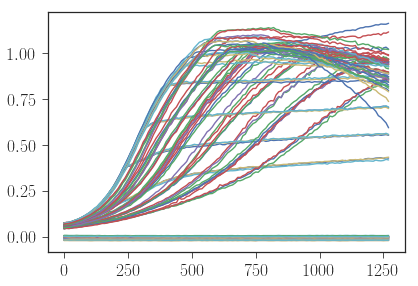

In [30]:
for name, cur_data in combined_data.groupby('Well'):
    plt.plot(cur_data['time'], cur_data['pop_OD'])

# Vaying dextrose (sugar) concentration

Let's grab the cultures where we varied dextrose. Let's analyze their behavior.

In [33]:
dex_data = combined_data.loc[combined_data['Condition'] == 'dex']

In [35]:
unique_dex_amounts = dex_data['Number'].unique()
unique_dex_amounts.sort()

unique_dex_amounts # The values of dextrose that we used

array([ 0.1,  0.5,  1. ,  2. ,  3. ,  4. ,  5. ])

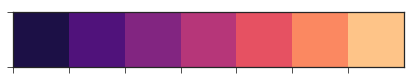

In [36]:
colors = sns.color_palette(palette='magma', n_colors = len(unique_dex_amounts))
sns.palplot(colors)

Plotting the dextrose data alone,

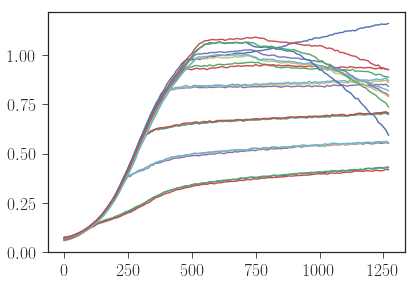

In [37]:
for name, cur_data in dex_data.groupby('Well'):
    plt.plot(cur_data['time'], cur_data['pop_OD'])

Let us now appropriately label the data!

In [38]:
plt.rc('text', usetex=True)

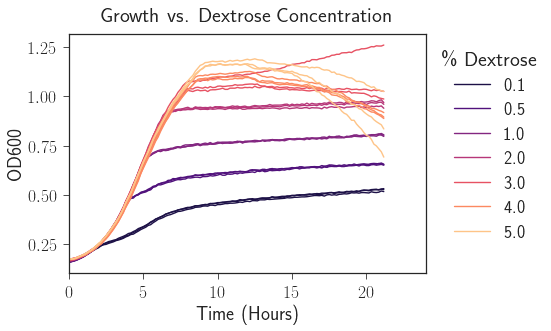

In [39]:
for name, cur_data in dex_data.groupby('Well'):
    x = cur_data['time'].values / 60.0 # Hours
    y = cur_data['OD600']
    
    dex_conc = cur_data['Number'].iloc[0]
    color_index = np.where(unique_dex_amounts == dex_conc)[0][0]
    cur_color = colors[color_index]
    
    plt.plot(x, y, ls='-', color=cur_color, label='')
    
# Now for the labels
count = 0
for cur_conc in unique_dex_amounts:
    plt.plot([],[], ls='-', label=cur_conc, color=colors[count])
    count += 1
    
plt.legend(loc='upper left', title=r'\% Dextrose', bbox_to_anchor = (1.0, 1.0))

plt.xlabel('Time (Hours)')
plt.ylabel('OD600')

plt.title('Growth vs. Dextrose Concentration', y=1.03)

plt.xlim(0, 24)

plt.savefig('od_vs_dextrose.pdf', bbox_inches='tight')
plt.savefig('od_vs_dextrose.png', dpi=300, bbox_inches='tight')

Good. Increasing the amount of dextrose in the media allows the microbes to reach a larger final population before they plateau. Something strange happens at dextrose concentrations above 3%, there appears to be a rapid falloff of absorbance.

# Cycloheximide: a drug that slows growth

We created a mixture of the drug at high temperature and at low temperature; we wanted to check if it made any difference.

## Room temp

In [40]:
cyclo_data = combined_data.loc[combined_data['Condition'] == 'cyclo room']

In [41]:
unique_cyclo_amounts = cyclo_data['Number'].unique()
unique_cyclo_amounts.sort()
#unique_cyclo_amounts = unique_cyclo_amounts[::-1]

unique_cyclo_amounts

array([  50.,  100.,  150.,  200.,  300.,  400.,  500.])

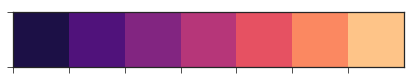

In [42]:
colors = sns.color_palette(palette='magma', n_colors = len(unique_cyclo_amounts))
sns.palplot(colors)

Plotting all of the room-temperature cyclohexamide data,

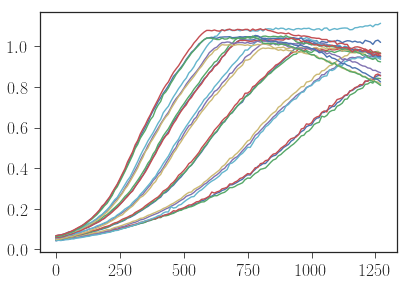

In [43]:
for name, cur_data in cyclo_data.groupby('Well'):
    plt.plot(cur_data['time'], cur_data['pop_OD'])

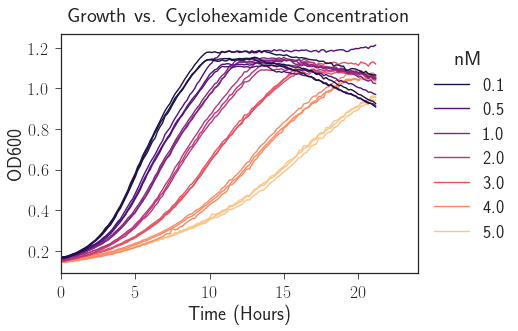

In [44]:
for name, cur_data in cyclo_data.groupby('Well'):
    x = cur_data['time'].values / 60.0 # Hours
    y = cur_data['OD600']
    
    cyclo_conc = cur_data['Number'].iloc[0]
    color_index = np.where(unique_cyclo_amounts == cyclo_conc)[0][0]
    cur_color = colors[color_index]
    
    plt.plot(x, y, ls='-', color=cur_color, label='')
    
# Now for the labels
count = 0
for cur_conc in unique_dex_amounts:
    plt.plot([],[], ls='-', label=cur_conc, color=colors[count])
    count += 1
    
    
plt.legend(loc='best', title=r'nM', bbox_to_anchor = (1.0, 1.0))

plt.xlabel('Time (Hours)')
plt.ylabel('OD600')
plt.title('Growth vs. Cyclohexamide Concentration', y=1.03)

plt.xlim(0, 24)

plt.savefig('cyclo_room.pdf', bbox_inches='tight')
plt.savefig('cyclo_room.png', dpi=300, bbox_inches='tight')

Indeed, increasing cyclohexamide concentration *decreases* the growth rate of cells. Is there a difference when we brewed the cyclohexamide at hot temperatures?

## 70C Cycloheximide

In [45]:
cyclo_hot_data = combined_data.loc[combined_data['Condition'] == 'cyclo hot']

Ok. Let's plot by color now with my new, sophisticated techniques...

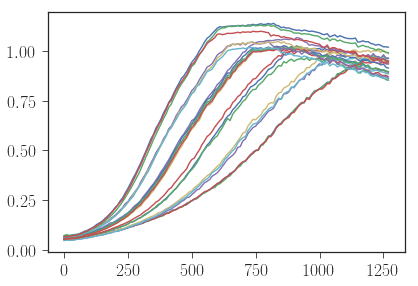

In [46]:
for name, cur_data in cyclo_hot_data.groupby('Well'):
    plt.plot(cur_data['time'], cur_data['pop_OD'])

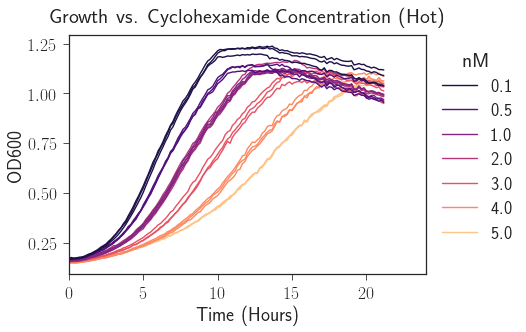

In [47]:
for name, cur_data in cyclo_hot_data.groupby('Well'):
    x = cur_data['time'].values / 60.0 # Hours
    y = cur_data['OD600']
    
    cyclo_conc = cur_data['Number'].iloc[0]
    color_index = np.where(unique_cyclo_amounts == cyclo_conc)[0][0]
    cur_color = colors[color_index]
    
    plt.plot(x, y, ls='-', color=cur_color, label='')
    
# Now for the labels
count = 0
for cur_conc in unique_dex_amounts:
    plt.plot([],[], ls='-', label=cur_conc, color=colors[count])
    count += 1
    
    
plt.legend(loc='best', title=r'nM', bbox_to_anchor = (1.0, 1.0))

plt.xlabel('Time (Hours)')
plt.ylabel('OD600')
plt.title('Growth vs. Cyclohexamide Concentration (Hot)', y=1.03)

plt.xlim(0, 24)

plt.savefig('cyclo_hot.pdf', bbox_inches='tight')
plt.savefig('cyclo_hot.png', dpi=300, bbox_inches='tight')

## Comparing hot and room temperature

Let's compare the growth in the two cyclohexamide scenarisos (hot and cold).

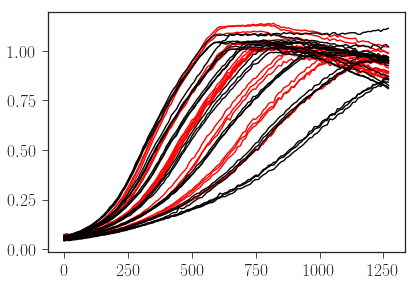

In [48]:
for name, cur_data in cyclo_hot_data.groupby('Well'):
    plt.plot(cur_data['time'], cur_data['pop_OD'], color='red')
    
for name, cur_data in cyclo_data.groupby('Well'):
    plt.plot(cur_data['time'], cur_data['pop_OD'], color='black')

# Growth rate vs. cyclohexamide concentration

We now want to actually extract the growth rate of our microbes. We can do this by using a script in the main package that works as follows:

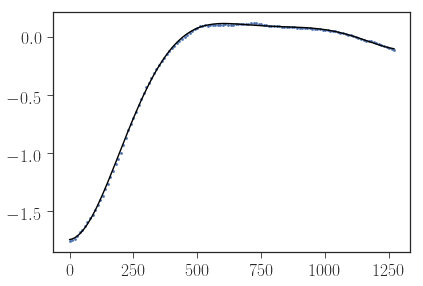

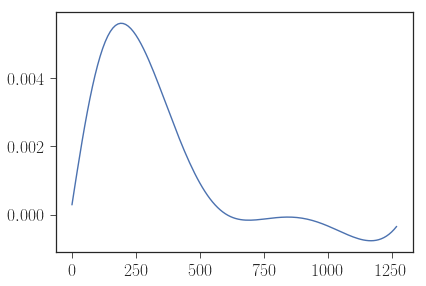

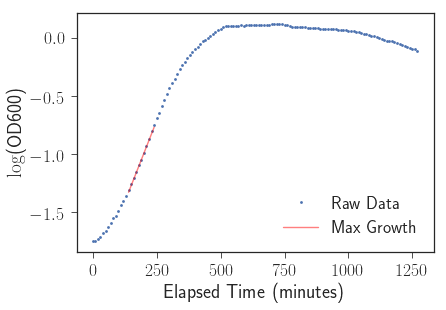

In [49]:
experiment.plot_growth_prediction('F1', minutes_around_max=50, debug=True)

The first plot is the raw absorbance data vs. time. The second plot is the derivative of the absorbance. Based on the location where the growth rate of the cells is the maximum, we fit the growth rate (i.e. the slope) as seen in the third plot (the red line).

Applying this to our data, using the ``get_max_growth_rate()`` command,

In [50]:
experiment.data -= average_blank

In [55]:
experiment.s= 0.4

In [56]:
growth_rate_data = []

for name, cur_data in cyclo_data.groupby('Well'):
    #plt.figure()
    #experiment.plot_growth_prediction(name, minutes_around_max=30)
    growth_rate = experiment.get_max_growth_rate(name)[0]
    
    conc = cur_data['Number'].iloc[0]
    growth_rate_data.append([growth_rate, conc, 'room'])

In [57]:
growth_df = pd.DataFrame(data = growth_rate_data, columns=['growth_rate', 'cyclo_conc', 'condition'])

In [59]:
growth_df.head(5)

,growth_rate,cyclo_conc,condition
0,0.003600,500.0,room
1,0.003289,500.0,room
2,0.003331,500.0,room
3,0.004219,400.0,room
4,0.003653,400.0,room


Ok, we have the growth rate when we apply cyclohexamide. Getting the control growth rate (no cyclohexamide),

In [60]:
control_growth = dex_data.loc[dex_data['Number'] == 5.0]

control_list = []

for name, cur_data in control_growth.groupby('Well'):
    #plt.figure()
    #experiment.plot_growth_prediction(name, minutes_around_max=30)
    growth_rate = experiment.get_max_growth_rate(name)[0]
    
    conc = 0.0
    # It's the same 0 concentration for both room and hot
    control_list.append([growth_rate, conc, 'room'])
    control_list.append([growth_rate, conc, 'hot'])

In [61]:
control_df = pd.DataFrame(data = control_list, columns=['growth_rate', 'cyclo_conc', 'condition'])

We now just need to get the hot cyclohexamide data...

In [63]:
hot_data = []

for name, cur_data in cyclo_hot_data.groupby('Well'):
    #plt.figure()
    #experiment.plot_growth_prediction(name, minutes_around_max=30)
    growth_rate = experiment.get_max_growth_rate(name)[0]
    
    conc = cur_data['Number'].iloc[0]
    hot_data.append([growth_rate, conc, 'hot'])

In [64]:
hot_df = pd.DataFrame(data = hot_data, columns=['growth_rate', 'cyclo_conc', 'condition'])

Combining all of the different growth rates into a single dataframe,

In [65]:
all_growth_df = pd.concat((growth_df, control_df, hot_df))

Plotting the growth rates,

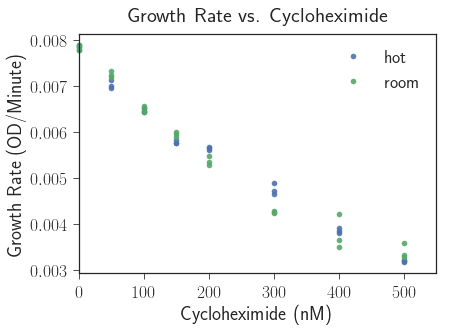

In [67]:
for name, cur_data in all_growth_df.groupby('condition'):
    plt.plot(cur_data['cyclo_conc'], cur_data['growth_rate'], ls = '', marker='o', alpha=0.9, 
             clip_on=False, label=name)
    
plt.legend(loc='best')
plt.xlabel('Cycloheximide (nM)')
plt.ylabel('Growth Rate (OD/Minute)')

plt.title('Growth Rate vs. Cycloheximide', y=1.03)

plt.xlim(0, 550)

plt.savefig('growth_rate_vs_cyclo.pdf', bbox_inches='tight')
plt.savefig('growth_rate_vs_cyclo.png', bbox_inches='tight', dpi=300)

Beautiful. Let's extract $s=g_1/g_0 - 1$ now, or the decrease in growth rate $g_1$ due to the presence of cyclohexamide relative to the initial growth rate $g_0$.

In [68]:
import scipy as sp

In [69]:
mean_growth = all_growth_df.groupby(['cyclo_conc', 'condition']).agg([np.mean, sp.stats.sem]).reset_index()

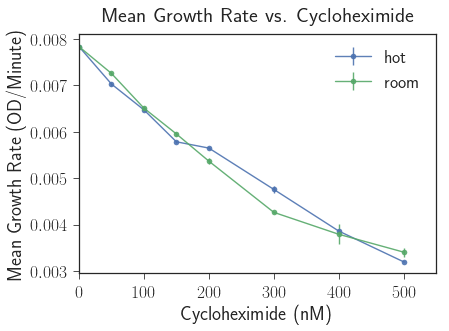

In [70]:
for name, cur_data in mean_growth.groupby('condition'):
    x = cur_data['cyclo_conc'].values
    y = cur_data['growth_rate', 'mean'].values
    yerr = cur_data['growth_rate', 'sem'].values
    
    plt.errorbar(x, y, yerr=yerr, ls='-', marker='o', label=name, alpha=.9)
        
plt.legend(loc='best')
plt.xlabel('Cycloheximide (nM)')
plt.ylabel('Mean Growth Rate (OD/Minute)')

plt.title('Mean Growth Rate vs. Cycloheximide', y=1.03)

plt.xlim(0, 550)

plt.savefig('growth_rate_vs_cyclo_mean.pdf', bbox_inches='tight')
plt.savefig('growth_rate_vs_cyclo_mean.png', bbox_inches='tight', dpi=300)

Excellent. Let's extract s now. The fitness *disadvantage* when applying the drug...

In [71]:
base_growth = mean_growth.loc[mean_growth['cyclo_conc'] == 0].iloc[0]['growth_rate', 'mean']

In [72]:
mean_growth['s'] = mean_growth['growth_rate', 'mean']/base_growth - 1.0

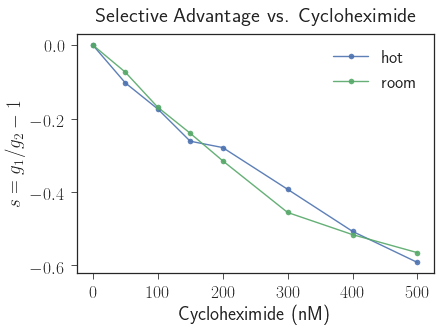

In [73]:
for name, cur_data in mean_growth.groupby('condition'):
    x = cur_data['cyclo_conc'].values
    y = cur_data['s'].values
    
    plt.plot(x, y, ls='-', marker='o', label=name, alpha=.9, clip_on=False)
        
plt.legend(loc='best')
plt.xlabel('Cycloheximide (nM)')
plt.ylabel(r'$s = g_1/g_2 - 1$')

plt.title('Selective Advantage vs. Cycloheximide', y=1.03)

# plt.xlim(0, 550)

plt.savefig('s_vs_cyclo_mean.pdf', bbox_inches='tight')
plt.savefig('s_vs_cyclo_mean.png', bbox_inches='tight', dpi=300)

Indeed, applying cycloheximide, an antibiotic, in large amounts can almost cut the growth rate of microbes in half!